In [24]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


In [25]:
# Загрузка и нормализация данных
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)
y = iris.target

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Перенос на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [26]:
# Блок Mamba
class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.fc1 = nn.Linear(d_input, d_model)
        self.attn = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, d_input)
        self.act = nn.GELU()

    def forward(self, x):
        shortcut = x
        x = self.act(self.fc1(x))
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = x * attn_weights
        x = self.fc2(x)
        return x + shortcut, attn_weights

# Модель на основе Mamba
class IrisMambaModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, num_layers=3, num_classes=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            MambaBlock(input_dim, hidden_dim) for _ in range(num_layers)
        ])
        self.head = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, num_classes)
        )

    def forward(self, x):
        attention_layers = []
        for block in self.blocks:
            x, attn = block(x)
            attention_layers.append(attn)
        return self.head(x), attention_layers

In [27]:
# Инициализация модели
model = IrisMambaModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Обучение
EPOCHS = 1000
loss_log = []

print("Начало обучения модели...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    outputs, _ = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_out, _ = model(X_test_tensor)
        val_loss = criterion(val_out, y_test_tensor)

    scheduler.step(val_loss)
    loss_log.append((loss.item(), val_loss.item()))

    if epoch % 100 == 0:
        print(f"Эпоха {epoch:4d} | Train: {loss.item():.4f} | Val: {val_loss.item():.4f}")

Начало обучения модели...
Эпоха  100 | Train: 0.7970 | Val: 0.8084
Эпоха  200 | Train: 0.2476 | Val: 0.2150
Эпоха  300 | Train: 0.0654 | Val: 0.0237
Эпоха  400 | Train: 0.0548 | Val: 0.0141
Эпоха  500 | Train: 0.0548 | Val: 0.0141
Эпоха  600 | Train: 0.0548 | Val: 0.0141
Эпоха  700 | Train: 0.0548 | Val: 0.0141
Эпоха  800 | Train: 0.0548 | Val: 0.0141
Эпоха  900 | Train: 0.0548 | Val: 0.0141
Эпоха 1000 | Train: 0.0548 | Val: 0.0141


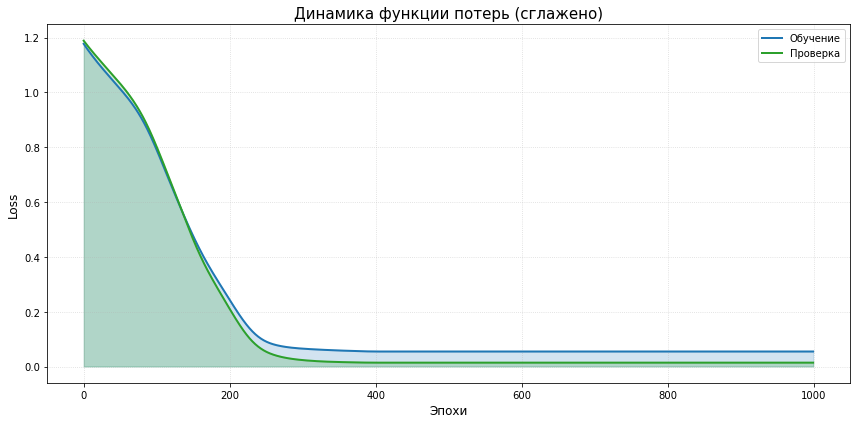

In [28]:
# Сглаживание и визуализация потерь
train_loss, val_loss = zip(*loss_log)
x_epochs = np.arange(len(train_loss))
smooth_train = savgol_filter(train_loss, 51, 3)
smooth_val = savgol_filter(val_loss, 51, 3)

plt.figure(figsize=(12, 6))
plt.plot(x_epochs, smooth_train, label='Обучение', color='#1f77b4', linewidth=2)
plt.fill_between(x_epochs, smooth_train, alpha=0.2, color='#1f77b4')

plt.plot(x_epochs, smooth_val, label='Проверка', color='#2ca02c', linewidth=2)
plt.fill_between(x_epochs, smooth_val, alpha=0.2, color='#2ca02c')

plt.title("Динамика функции потерь (сглажено)", fontsize=15)
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
# Точность
def accuracy(model, features, labels):
    model.eval()
    with torch.no_grad():
        preds, _ = model(features)
        return (preds.argmax(dim=1) == labels).float().mean().item()

train_acc = accuracy(model, X_train_tensor, y_train_tensor)
test_acc = accuracy(model, X_test_tensor, y_test_tensor)

print("\nРезультаты точности:")
print(f"   Train Accuracy : {train_acc * 100:.2f}%")
print(f"   Test Accuracy  : {test_acc * 100:.2f}%")


Результаты точности:
   Train Accuracy : 98.10%
   Test Accuracy  : 100.00%


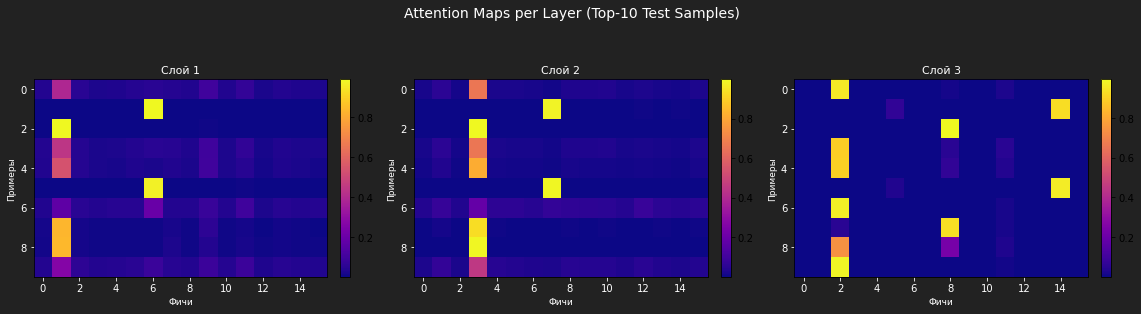

In [30]:
# Визуализация внимания
model.eval()
with torch.no_grad():
    _, attn_maps = model(X_test_tensor[:10])

fig, axs = plt.subplots(1, len(attn_maps), figsize=(16, 4), facecolor="#222")
fig.suptitle("Attention Maps per Layer (Top-10 Test Samples)", fontsize=14, color='white', y=1.08)

for i, (attn, ax) in enumerate(zip(attn_maps, axs)):
    attn_np = attn.cpu().numpy()
    im = ax.imshow(attn_np, cmap='plasma', aspect='auto')
    ax.set_title(f"Слой {i+1}", fontsize=11, color='white')
    ax.set_xlabel("Фичи", fontsize=9, color='white')
    ax.set_ylabel("Примеры", fontsize=9, color='white')
    ax.tick_params(colors='white')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Слой 1:
у некоторых признаков повышенное внимание, модель начинает выделять признаки

Слой 2:
Внимание начинает фокусироваться: появляются ярко выраженные активации на отдельных признаках.

Примеры демонстрируют разную степень важности признаков — модель начинает различать объекты по структуре.

Слой 3:
Очень концентрированные зоны внимания.

Модель чётко выделяет немногочисленные признаки, которые являются решающими для классификации.

Карта содержит резко выраженные активации (жёлтые/оранжевые), особенно по горизонтали — что указывает на индивидуальную настройку внимания на уровне каждого примера.



## выводы
Архитектура с блоками внимания доказала свою эффективность даже на простом датасете.

Каждый слой по-своему трансформирует входные данные, начиная с широкого восприятия и заканчивая детализированной фильтрацией.

Модель адаптивна, внимание разное для каждого примера — это ключевой элемент в объяснимости решений.

Такая схема обработки может быть масштабирована на более сложные датасеты, где скрытые взаимосвязи между признаками не так очевидны.

